<a href="https://www.kaggle.com/code/fahmirk/scraping-e-ipo-data-using-selenium?scriptVersionId=135261614" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## This notebook will explain how Chrome Driver and Selenium in Python can scrape data available on the e-IPO (Electronic Indonesia Public Offering) website in Realtime.

The notebook can be used to scrape all the company data available on the e-IPO website in real time, as long as the structure of the website is not changed (only the data of the company that is going to IPO is added).

**Notes**: If there is a change in the website structure, I may revise this notebook so that it can work properly.

**Disclaimer**: There may be some mistakes in this notebook because I am not an expert, but I'm glad it works. Some of the sources I used in making this notebook are Kaggle and Stack Overflow. I am very happy if you make this as a reference. Please criticize and suggest.

## Prerequisite

In [1]:
#Update
!apt-get update -y

#Installing the libraries used in this notebook
!apt-get install -y \
libglib2.0-0 \
libnss3 \
libdbus-glib-1-2 \
libgconf-2-4 \
libfontconfig1 \
gconf2-common \
libwayland-server0 \
libgbm1 \
udev \
libu2f-udev

#Fix any broken dependencies that might occur during the installation process
!sudo apt --fix-broken install -y

Get:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]
Get:2 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 http://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [2356 B]
Get:7 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [471 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2856 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1366 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1066 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2479 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-update

In [2]:
#Install google chrome
!wget -nc -P /usr/lib https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i /usr/lib/google-chrome-stable_current_amd64.deb

--2023-06-29 15:36:26--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.google.com)... 74.125.199.136, 74.125.199.91, 74.125.199.190, ...
Connecting to dl.google.com (dl.google.com)|74.125.199.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94327756 (90M) [application/x-debian-package]
Saving to: ‘/usr/lib/google-chrome-stable_current_amd64.deb’

google-chrome-stabl 100%[===================>]  89.96M   120MB/s    in 0.7s    

2023-06-29 15:36:27 (120 MB/s) - ‘/usr/lib/google-chrome-stable_current_amd64.deb’ saved [94327756/94327756]

Selecting previously unselected package google-chrome-stable.
(Reading database ... 110153 files and directories currently installed.)
Preparing to unpack .../google-chrome-stable_current_amd64.deb ...
Unpacking google-chrome-stable (114.0.5735.198-1) ...
Setting up google-chrome-stable (114.0.5735.198-1) ...
update-alternatives: using /usr/bin/google-chrome-stable to prov

In [3]:
#Install chromedriver
!wget -nc -P /usr/lib https://chromedriver.storage.googleapis.com/114.0.5735.90/chromedriver_linux64.zip

--2023-06-29 15:36:38--  https://chromedriver.storage.googleapis.com/114.0.5735.90/chromedriver_linux64.zip
Resolving chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c03::80
Connecting to chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7407250 (7.1M) [application/zip]
Saving to: ‘/usr/lib/chromedriver_linux64.zip’

chromedriver_linux6 100%[===================>]   7.06M  --.-KB/s    in 0.05s   

2023-06-29 15:36:38 (135 MB/s) - ‘/usr/lib/chromedriver_linux64.zip’ saved [7407250/7407250]



In [4]:
#Create new directory named "Chrome-browser"
!mkdir /usr/lib/chrome-browser

#Unzip chromedriver_linux64.zip and extracts its contents to "/usr/lib/chrome-browser/" directory
!unzip -o /usr/lib/chromedriver_linux64.zip -d /usr/lib/chrome-browser/

Archive:  /usr/lib/chromedriver_linux64.zip
  inflating: /usr/lib/chrome-browser/chromedriver  
  inflating: /usr/lib/chrome-browser/LICENSE.chromedriver  


In [5]:
#Install Selenium
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 29.9 MB/s eta 0:00:00


## Preparation

First, import all libraries used in this notebook

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ChromeOptions
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
import re
import pandas as pd
from PIL import Image
import sys
import numpy as np
import time
from io import BytesIO
sys.path.insert(0,'/usr/lib/chrome-browser/chromedriver')
pd.set_option('display.max_columns', None)

Here I created some functions that are used in this notebook to make work easier.

In [7]:
#Function
def Status_IPO(text):
    klasifikasi = ["Pre-Effective",
               "Book Building",
               "Offering",
               "Allotment",
               "Closed",
               "Canceled"]
    klasifikasi = klasifikasi[::-1]
    status = [item for item in klasifikasi if item in text]
    if len(set(status)) == 1:
        return(status[0])
    else:
        status.remove("Book Building")
        return(status[0])
    
def is_string_unique(string, lst):
    return lst.count(string) == 1

def book_building_period(text):
    if is_string_unique("Book Building",text):
        return(data[data.index("Book Building") + 1])
    else:
        second_index = -1
        count = 0
        for index, element in enumerate(text):
            if element == "Book Building":
                count += 1
                if count == 2:
                    second_index = index
        return(data[second_index+1])

def book_building_price(text):
    if is_string_unique("Book Building",text):
        return(data[data.index("Book Building") + 2])
    else:
        second_index = -1
        count = 0
        for index, element in enumerate(text):
            if element == "Book Building":
                count += 1
                if count == 2:
                    second_index = index
        return(data[second_index+2])

def convert_to_integer(df, columns):
    for column in columns:
        df[column] = df[column].str.replace(',', '', regex=True).where(df[column].notnull(), np.nan)
        df[column] = df[column].str.replace('IDR ', '').astype('Int64').where(df[column].notnull(), np.nan)
    return df

def warrant_per_share_ratio(warantdata):
    if warantdata is None:
        return np.nan
    elif ':' in warantdata:
        warantdata = warantdata.split(':')
        return (float(warantdata[1]) / float(warantdata[0]))
    else:
        return warantdata

def extract_underwriters(df, column):
    df[column] = df[column].apply(lambda x: [re.sub(r'\s*-\s*.*$', '', item) for item in x])
    df[column] = df[column].apply(lambda x: ','.join(x))
    return df[column]

def extract_participant_admin(df, column):
    df[column] = df[column].apply(lambda x: re.sub(r'\s*-\s*.*$', '', x))
    return df[column]
    
def update_database(data):
    #Mengambil data dari halaman perusahaan yang akan melakukan IPO
    newvalue = [
        None,  # Placeholder for Status_IPO
        None,  # Placeholder for Nama
        None,  # Placeholder for Kode
        None,  # Placeholder for Sektor
        None,  # Placeholder for Subsektor
        None,  # Placeholder for LOB
        None,  # Placeholder for Address
        None,  # Placeholder for Website
        None,  # Placeholder for Shares_offered
        None,  # Placeholder for Percentage_total_shares
        None,  # Placeholder for Participant_admin
        None,  # Placeholder for UW
        None,  # Placeholder for BB_Period
        None,  # Placeholder for BB_Price
        None,  # Placeholder for Offering_Period
        None,  # Placeholder for Final_Price
        None,  # Placeholder for Allotment
        None,  # Placeholder for Distribution
        None,  # Placeholder for Listing
        None,  # Placeholder for Warrant
        None   # Placeholder for Exercise
    ]

    try:
        newvalue[0] = Status_IPO(data)
    except ValueError:
        pass

    try:
        newvalue[1] = data[0]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[2] = data[2]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[3] = data[data.index("Sector") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[4] = data[data.index("Subsector") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[5] = data[data.index("Line Of Business") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[6] = data[data.index("Address") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[7] = data[data.index("Website") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[8] = int(re.sub(r'[^\d]', '', data[data.index("Number of shares offered") + 1]))
    except (ValueError, IndexError):
        pass

    try:
        newvalue[9] = float(data[data.index("% of Total Shares") + 1])
    except (ValueError, IndexError):
        pass

    try:
        newvalue[10] = data[data.index("Participant Admin") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[11] = data[data.index("Underwriter(s)")+1:data.index(Status_IPO(data))]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[12] = book_building_period(data)
    except (ValueError, IndexError):
        pass

    try:
        newvalue[13] = book_building_price(data)
    except (ValueError, IndexError):
        pass

    try:
        newvalue[14] = data[data.index("Offering") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[15] = data[data.index("Offering") + 2]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[16] = data[data.index("Allotment (Closing)") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[17] = data[data.index("Distribution") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[18] = data[data.index("Listing Date") + 1]
    except (ValueError, IndexError):
        pass
    
    try:
        newvalue[19] = data[data.index("Warant") + 1]
    except (ValueError, IndexError):
        pass
    
    try:
        if "IDR" not in data[data.index("Exercise Price") + 1]:
            raise ValueError
        else:
            newvalue[20] = data[data.index("Exercise Price") + 1]
    except (ValueError, IndexError):
        pass
    
    #Update Data
    for key, new_value in zip(database.keys(), newvalue):
        database[key].append(new_value)

## Scraping Data Website e-IPO

After importing the libraries and declaring some functions, we can start extracting information from the e-IPO website. (https://www.e-ipo.co.id/en/ipo/index)

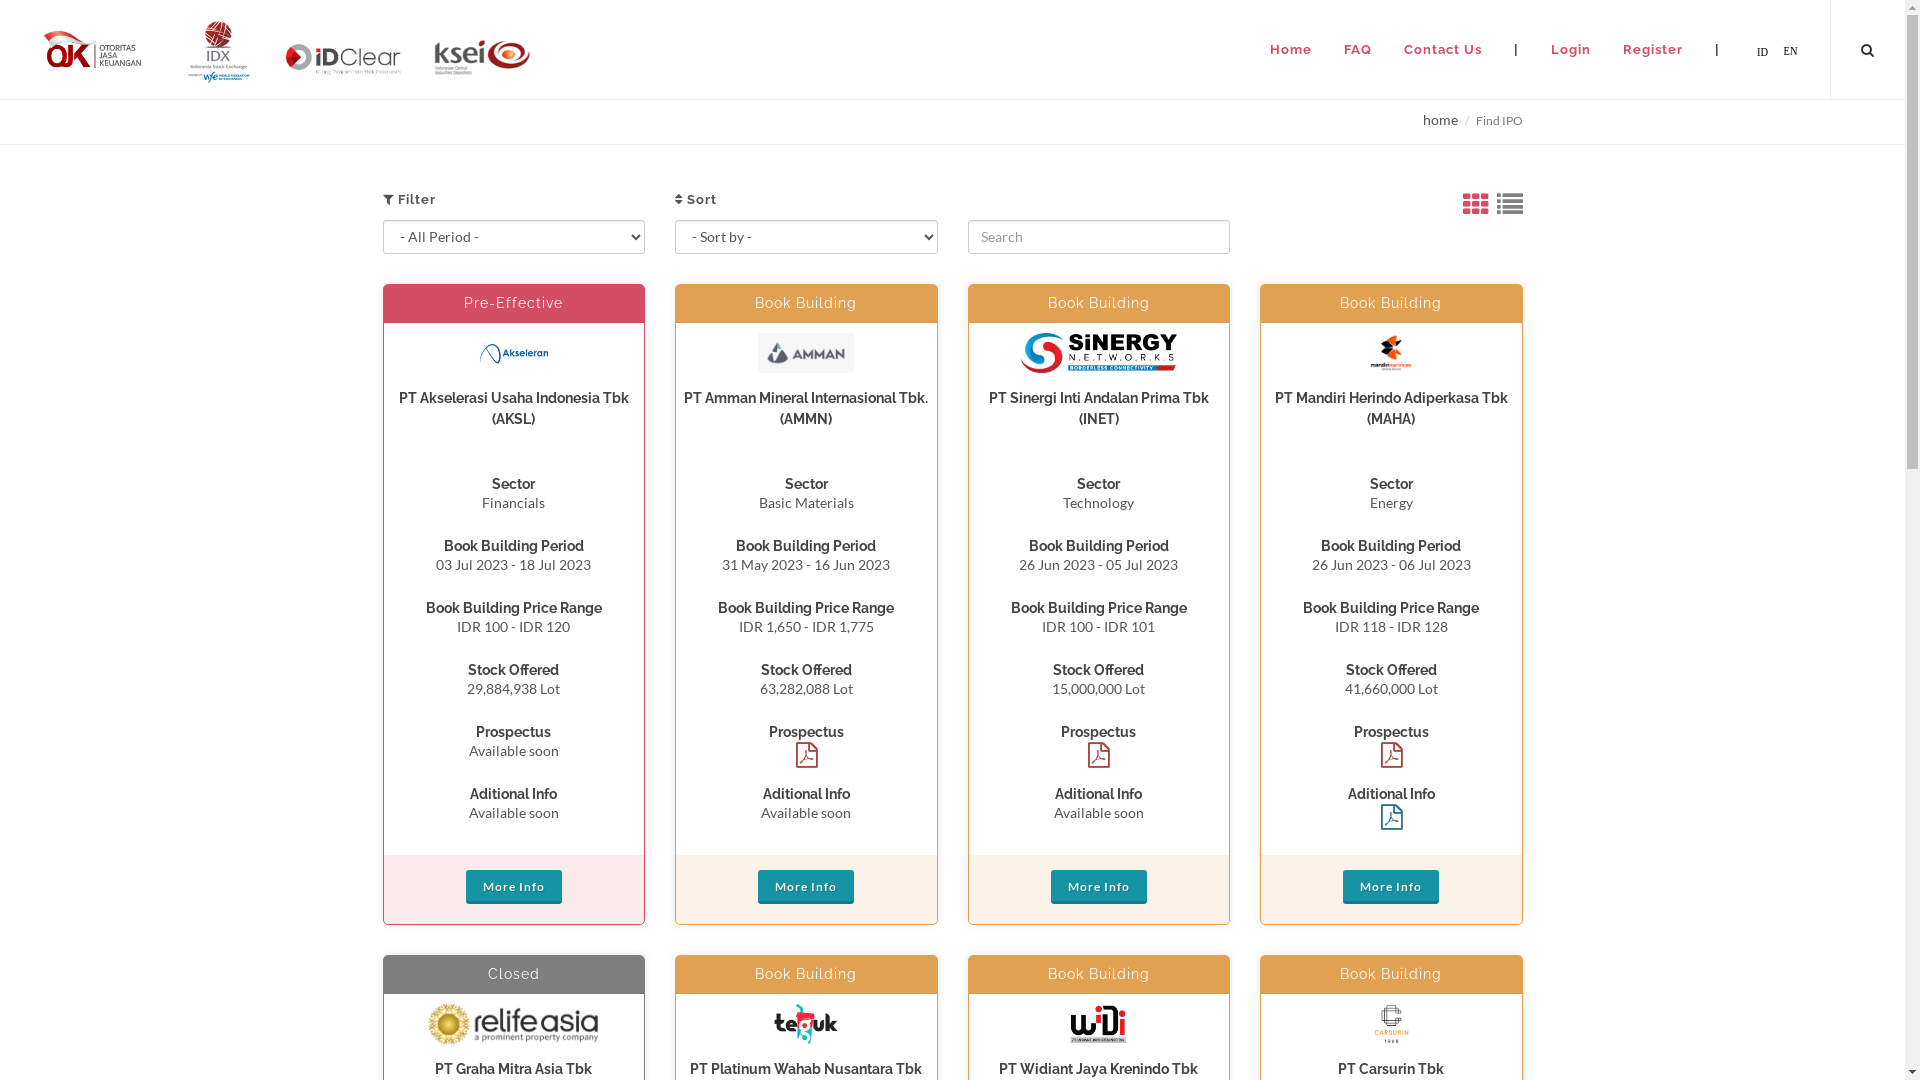

In [8]:
#Create Connection
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')                             
options.add_argument('--disable-dev-shm-usage')
options.add_argument('user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36')
options.add_argument("--window-size=1920,1080")
driver = webdriver.Chrome(service=Service(executable_path='/usr/lib/chrome-browser/chromedriver'),options=options)


url = "https://www.e-ipo.co.id/en/ipo/index"
driver.get(url)

time.sleep(3) #Wait 3 seconds for the website to display perfectly so we can get a screenshot in the next code

#Take a screenshot of the website and display it.
img = Image.open(BytesIO(driver.get_screenshot_as_png()))
img

It is known that on each page there are 12 companies, so on each page we will iterate to retrieve company information **12 times**, shown with the following code:
>for j in range(12):

On the last page, it may happen that the list of companies is **less than or equal to 12**, so I will use the "break" statement to stop the process like this:
>try:</br>
>&emsp;link = row.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j+1)+']/div/div/div[5]/a').get_attribute('href')</br>
>except NoSuchElementException:</br>
>&emsp;print('Page ' + str(i) + ': Success. There is no more information')</br>
>&emsp;break

In [9]:
#Create a database in the form of a dictionary
keyList = ["IPO Status",
           "Ticker Code",
           "Company Name",
           "Sector",
           "Subsector",
           "Line of Business",
           "Address",
           "Website",
           "Number of shares offered",
           "% of Total Shares",
           "Participant Admin",
           "Underwriter(s)",
           "Book Building Period",
           "Book Building Price",
           "Offering Period",
           "Final Price (Rp)",
           "Closing Date",
           "Distribution Date",
           "Listing Date",
           "Warrant",
           "Exercise Price (Warrant) (Rp)"
          ]

database = {key: [] for key in keyList}

#Iterations for each page
timeout = 10 # The process is stopped when the website does not respond within 10 seconds.

i=1 #Set i for iteration


print("Data Scraping Process")
driver.get(url)

while True:
    driver.get('https://www.e-ipo.co.id/en/ipo/index?page=' + str(i) + '&per-page=12')
    
    #Looking for an element that holds a list of companies so that we can search for links to each company
    row = driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]')

    try:
        WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, '/*')))

    except TimeoutException:
        print("Timed out waiting for Response")
        break
            
    #Iteration to retrieve information from each company that will conduct an IPO on each page.
    for j in range(12):
        #Each company's link will appear in the "link" variable
        try:
            link = row.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j+1)+']/div/div/div[5]/a').get_attribute('href')
        
        except NoSuchElementException:
            print('Page ' + str(i) + ': Success. There is no more information')
            break

        #Access company links
        driver.get(link)
        
        #This script will be used in "WebDriverWait" so that the next code will run when the element with ID "wrapper"
        #has animationDuration equal to "1.5s" and opacity equal to "1".
        #Once the conditions are met,the Python code execution will continue.
        script = """
            var element = document.getElementById("wrapper");
            var styles = window.getComputedStyle(element);
            var animationDuration = styles.animationDuration;
            var opacity = styles.opacity;
            return (animationDuration === "1.5s" && opacity === "1");
        """
        try:
            WebDriverWait(driver, timeout).until(lambda driver: driver.execute_script(script))
            
            #The company information is taken from the element in '//*[@id="wrapper"]/section[2]/div/div/div[2]'
            #which is converted into text. Then the resulting text is converted into a list with a delimiter '\n' (New Line)
            #and this list will be declared as a new variable called "data".
            data = driver.find_element(By.XPATH,'//*[@id="wrapper"]/section[2]/div/div/div[2]').text.split('\n')

        except TimeoutException:
            print("Timed out waiting for Response")
            break
        
        #Update the database with functions that have been created in the preparation step.
        update_database(data)

        #Exit from the company page
        driver.get('https://www.e-ipo.co.id/en/ipo/index?page=' + str(i) + '&per-page=12')
        row = driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]')
    else:
        print("Page " + str(i) + " : Success")
        i += 1
        continue
    print("Process Completed")
    break

Data Scraping Process
Page 1 : Success
Page 2 : Success
Page 3 : Success
Page 4 : Success
Page 5 : Success
Page 6 : Success
Page 7 : Success
Page 8 : Success
Page 9 : Success
Page 10 : Success
Page 11 : Success
Page 12 : Success
Page 13: Success. There is no more information
Process Completed


After the data is stored in the form of a dictionary, the data will be displayed in the form of a Pandas DataFrame.

In [10]:
#Stores the database in the form of a dictionary into a pandas DataFrame
table = pd.DataFrame.from_dict(database)
table.head()

,IPO Status,Ticker Code,Company Name,Sector,Subsector,Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Period,Book Building Price,Offering Period,Final Price (Rp),Closing Date,Distribution Date,Listing Date,Warrant,Exercise Price (Warrant) (Rp)
0,Pre-Effective,PT Akselerasi Usaha Indonesia Tbk,AKSL,Financials,Financial Holdings,Penyedia LPBBTI atau P2P Lending melalui Entit...,"Sahid Sudirman Center Lantai 11 Unit G, Jl. Je...",https://www.akselerangroup.com,2988493800,29.00,OD - BRI DANAREKSA SEKURITAS,"[OD - BRI DANAREKSA SEKURITAS, SQ - BCA SEKURI...",03 Jul 2023 - 18 Jul 2023,IDR 100 - IDR 120,None,None,None,None,None,10 : 1,IDR 0
1,Book Building,PT Amman Mineral Internasional Tbk.,AMMN,Basic Materials,Copper,Aktivitas Perusahaan Holding,"Gedung Menara Karya Lantai 6 Unit A, B, C dan ...",https://www.amman.co.id,6328208800,8.80,CC - MANDIRI SEKURITAS,"[CC - MANDIRI SEKURITAS, DP - DBS VICKERS SEKU...",31 May 2023 - 16 Jun 2023,"IDR 1,650 - IDR 1,775",None,None,None,None,None,None,None
2,Book Building,PT Sinergi Inti Andalan Prima Tbk,INET,Technology,Networking Equipment,Bergerak di bidang Teknologi Informasi,"Gedung Cyber 1, Lantai 10, Jl. Kuningan Barat ...",https://siapnetworks.co.id/,1500000000,20.00,AH - SHINHAN SEKURITAS INDONESIA,[AH - SHINHAN SEKURITAS INDONESIA],26 Jun 2023 - 05 Jul 2023,IDR 100 - IDR 101,None,None,None,None,None,5 : 7,IDR 91
3,Book Building,PT Mandiri Herindo Adiperkasa Tbk,MAHA,Energy,Coal Distribution,Aktivitas jasa penunjang pertambangan,"Gedung Office 8, Lantai 31 Unit A Jl. Senopati...",https://www.mha.co.id,4166000000,25.00,LG - TRIMEGAH SEKURITAS INDONESIA TBK.,[LG - TRIMEGAH SEKURITAS INDONESIA TBK.],26 Jun 2023 - 06 Jul 2023,IDR 118 - IDR 128,None,None,None,None,None,None,None
4,Closed,PT Graha Mitra Asia Tbk,RELF,Properties & Real Estate,Real Estate Development & Management,Property & Real Estate,Sovereign Plaza Lt.5A Kav.36 Jl TB Simatupang ...,http://www.relifeasia.com/,1200000000,20.95,AI - UOB KAY HIAN SEKURITAS,[AI - UOB KAY HIAN SEKURITAS],25 May 2023 - 05 Jun 2023,IDR 90 - IDR 100,15 Jun 2023 - 20 Jun 2023,IDR 90,20 Jun 2023,21 Jun 2023,22 Jun 2023,1 : 1,IDR 125


Currently, the data is stored in the DataFrame. For the purpose of further analysis, the data is modified as follows:
1. Changing the columns containing date period data such as "Book Building Period" and "Offer Period" into 2 separate columns, namely the opening and closing columns.
2. Converting the Book Building Price from a range into two separate columns for the opening and closing prices.
3. Converting the price data into integer form.
4. Converting the security data into only the security code.
5. Converting the warrant data into the form of warrant per share ratio.
6. Converting columns containing categorical data into category form and converting columns containing date data into DateTime form

In [11]:
#Separates the column containing the range into two separate columns of opening and closing or lowest and highest.
table[['Book Building Opening', 'Book Building Closing']] = table['Book Building Period'].str.split(' - ', expand=True)
table.drop('Book Building Period', axis=1, inplace=True)
table.insert(12, 'Book Building Opening', table.pop('Book Building Opening'))
table.insert(13, 'Book Building Closing', table.pop('Book Building Closing'))

table[['Lowest Book Building Price (Rp)', 'Highest Book Building Price (Rp)']] = table['Book Building Price'].str.split(' - ', expand=True)
table.drop('Book Building Price', axis=1, inplace=True)
table.insert(14, 'Lowest Book Building Price (Rp)', table.pop('Lowest Book Building Price (Rp)'))
table.insert(15, 'Highest Book Building Price (Rp)', table.pop('Highest Book Building Price (Rp)'))

table[['Opening of Offering Period', 'Closing of Offering Period']] = table['Offering Period'].str.split(' - ', expand=True)
table.drop('Offering Period', axis=1, inplace=True)
table.insert(16, 'Opening of Offering Period', table.pop('Opening of Offering Period'))
table.insert(17, 'Closing of Offering Period', table.pop('Closing of Offering Period'))

#Convert the column containing the price to an integer
table = convert_to_integer(table, ['Lowest Book Building Price (Rp)',
                                   'Highest Book Building Price (Rp)',
                                   'Final Price (Rp)',
                                   'Exercise Price (Warrant) (Rp)'])

#Extract the column containing the security name to just the code and convert it to categorical form
extract_underwriters(table, 'Underwriter(s)')
extract_participant_admin(table, "Participant Admin")

#Converting warrant data into the form of warrant per share ratio
table['Warrant'] = table['Warrant'].apply(warrant_per_share_ratio)
table = table.rename(columns={'Warrant': 'Warrant per share ratio'})

#Convert columns containing categorical data into category form
listdate_column = ["Book Building Opening",
                  "Book Building Closing",
                  "Opening of Offering Period",
                  "Closing of Offering Period",
                  "Closing Date",
                  "Distribution Date",
                  "Listing Date"]
table[listdate_column] = table[listdate_column].apply(pd.to_datetime)

#Convert columns containing date data into DateTime form
listcategory_column = ["IPO Status",
                      "Sector",
                      "Subsector",
                      "Participant Admin",
                      "Underwriter(s)"]
table[listcategory_column] = table[listcategory_column].apply(lambda x: x.astype('category'))

#Display DataFrame
table.head()

,IPO Status,Ticker Code,Company Name,Sector,Subsector,Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Opening,Book Building Closing,Lowest Book Building Price (Rp),Highest Book Building Price (Rp),Opening of Offering Period,Closing of Offering Period,Final Price (Rp),Closing Date,Distribution Date,Listing Date,Warrant per share ratio,Exercise Price (Warrant) (Rp)
0,Pre-Effective,PT Akselerasi Usaha Indonesia Tbk,AKSL,Financials,Financial Holdings,Penyedia LPBBTI atau P2P Lending melalui Entit...,"Sahid Sudirman Center Lantai 11 Unit G, Jl. Je...",https://www.akselerangroup.com,2988493800,29.00,OD,"OD,SQ",2023-07-03,2023-07-18,100,120,NaT,NaT,<NA>,NaT,NaT,NaT,0.1,0
1,Book Building,PT Amman Mineral Internasional Tbk.,AMMN,Basic Materials,Copper,Aktivitas Perusahaan Holding,"Gedung Menara Karya Lantai 6 Unit A, B, C dan ...",https://www.amman.co.id,6328208800,8.80,CC,"CC,DP,IF,KZ,NI,OD,ZP",2023-05-31,2023-06-16,1650,1775,NaT,NaT,<NA>,NaT,NaT,NaT,NaN,<NA>
2,Book Building,PT Sinergi Inti Andalan Prima Tbk,INET,Technology,Networking Equipment,Bergerak di bidang Teknologi Informasi,"Gedung Cyber 1, Lantai 10, Jl. Kuningan Barat ...",https://siapnetworks.co.id/,1500000000,20.00,AH,AH,2023-06-26,2023-07-05,100,101,NaT,NaT,<NA>,NaT,NaT,NaT,1.4,91
3,Book Building,PT Mandiri Herindo Adiperkasa Tbk,MAHA,Energy,Coal Distribution,Aktivitas jasa penunjang pertambangan,"Gedung Office 8, Lantai 31 Unit A Jl. Senopati...",https://www.mha.co.id,4166000000,25.00,LG,LG,2023-06-26,2023-07-06,118,128,NaT,NaT,<NA>,NaT,NaT,NaT,NaN,<NA>
4,Closed,PT Graha Mitra Asia Tbk,RELF,Properties & Real Estate,Real Estate Development & Management,Property & Real Estate,Sovereign Plaza Lt.5A Kav.36 Jl TB Simatupang ...,http://www.relifeasia.com/,1200000000,20.95,AI,AI,2023-05-25,2023-06-05,90,100,2023-06-15,2023-06-20,90,2023-06-20,2023-06-21,2023-06-22,1.0,125


In [12]:
#View the data type of each column in the DataFrame
table.dtypes

IPO Status                                category
Ticker Code                                 object
Company Name                                object
Sector                                    category
Subsector                                 category
Line of Business                            object
Address                                     object
Website                                     object
Number of shares offered                     int64
% of Total Shares                          float64
Participant Admin                         category
Underwriter(s)                            category
Book Building Opening               datetime64[ns]
Book Building Closing               datetime64[ns]
Lowest Book Building Price (Rp)              Int64
Highest Book Building Price (Rp)             Int64
Opening of Offering Period          datetime64[ns]
Closing of Offering Period          datetime64[ns]
Final Price (Rp)                             Int64
Closing Date                   

The data has been collected and is ready to be exported into CSV.

In [13]:
#Save DataFrame to CSV
table.to_csv("e-IPO Data.csv", index=False)